## Use features and data about suppliers to predict whether products will go backorder.

### Content:<br/>
<ul>
    <li>Predicting and filling missing value<li/>
    Exploratory Data Analysis<li/>
    Oversampling unbalanced data<li/>
    Training models, predicting, and model evaluation<li/>
    Cost-Benefit Analysis
</ul>
    

In [43]:
#Load the two datasets: training and test
import pandas as pd
train_data = pd.read_csv(filepath_or_buffer = 'C:\\Users\\liuwe\\Google Drive\\Emory MSBA\\Machine Learning 2\\Final Project\\Kaggle_Training_Dataset_v2.csv'
                        ,header = 0,low_memory=False)
test_data = pd.read_csv(filepath_or_buffer = 'C:\\Users\\liuwe\\Google Drive\\Emory MSBA\\Machine Learning 2\\Final Project\\Kaggle_Test_Dataset_v2.csv'
                        ,header = 0,low_memory=False)

drop sku, which is just a assigned number

In [44]:
train_data = train_data.drop(labels='sku',axis = 1)
test_data = test_data.drop(labels='sku',axis = 1)

## Deal with missing data

In [45]:
train_data.describe()

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty
count,1.687860e+06,1.586967e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06
mean,4.961118e+02,7.872267e+00,4.405202e+01,1.781193e+02,3.449867e+02,5.063644e+02,5.592607e+01,1.750259e+02,3.417288e+02,5.252697e+02,5.277230e+01,2.043724e+00,-6.872059e+00,-6.437947e+00,6.264507e-01
std,2.961523e+04,7.056024e+00,1.342742e+03,5.026553e+03,9.795152e+03,1.437892e+04,1.928196e+03,5.192378e+03,9.613167e+03,1.483861e+04,1.254983e+03,2.360165e+02,2.655636e+01,2.584333e+01,3.372224e+01
min,-2.725600e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-9.900000e+01,-9.900000e+01,0.000000e+00
25%,4.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.300000e-01,6.600000e-01,0.000000e+00
50%,1.500000e+01,8.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00,8.200000e-01,8.100000e-01,0.000000e+00
75%,8.000000e+01,9.000000e+00,0.000000e+00,4.000000e+00,1.200000e+01,2.000000e+01,4.000000e+00,1.500000e+01,3.100000e+01,4.700000e+01,3.000000e+00,0.000000e+00,9.700000e-01,9.500000e-01,0.000000e+00
max,1.233440e+07,5.200000e+01,4.894080e+05,1.427612e+06,2.461360e+06,3.777304e+06,7.417740e+05,1.105478e+06,2.146625e+06,3.205172e+06,3.133190e+05,1.464960e+05,1.000000e+00,1.000000e+00,1.253000e+04


It looks like around 100,000 instances are missing attribute 'lead_time', which is a critical attribute for our business problem. Because shorter lead_time implies better logistics and less-likelihood to go out of stock, we don't want to simply drop instances with missing values. 

Some of the variables are yes/no. Code them with 1/0 instead. 

In [46]:
def boolean_to_int(x) :
    if x == 'Yes': return 1
    elif x == 'No': return 0
    else : return x

for i in train_data.columns :
    train_data[i] = [boolean_to_int(x) for x in train_data[i]]
    test_data[i] = [boolean_to_int(x) for x in test_data[i]]

We don't want to assume all the missing values are due to random chance. First seperate the training set into two parts by whether lead_time is missing, and see if we can detect any patterns when lead_time is missing.

In [47]:
train_with_na = train_data[train_data.isnull().any(axis=1)]
train_complete = train_data.dropna(axis=0, how='any')

In [48]:
na_stats = train_with_na.describe()
train_stats = train_complete.describe()

In [49]:
train_stats

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
count,1.586967e+06,1.586967e+06,1.586967e+06,1.586967e+06,1.586967e+06,1.586967e+06,1.586967e+06,1.586967e+06,1.586967e+06,1.586967e+06,...,1.586967e+06,1.586967e+06,1.586967e+06,1.586967e+06,1.586967e+06,1.586967e+06,1.586967e+06,1.586967e+06,1.586967e+06,1.586967e+06
mean,4.895098e+02,7.872267e+00,4.547493e+01,1.887439e+02,3.653390e+02,5.362801e+02,5.691140e+01,1.784835e+02,3.522319e+02,5.441272e+02,...,2.172666e+00,-1.014934e+00,-5.532225e-01,6.333207e-01,2.032538e-01,1.543825e-04,1.188090e-01,9.753675e-01,2.583545e-04,6.911927e-03
std,3.046168e+04,7.056024e+00,1.309357e+03,5.182992e+03,1.009962e+04,1.482576e+04,1.854775e+03,4.971129e+03,9.679297e+03,1.514871e+04,...,2.434021e+02,1.327273e+01,1.144580e+01,3.343933e+01,4.024199e-01,1.242412e-02,3.235638e-01,1.550025e-01,1.607134e-02,8.285021e-02
min,-2.725600e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,-9.900000e+01,-9.900000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,6.900000e-01,6.900000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
50%,1.400000e+01,8.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,3.000000e+00,4.000000e+00,...,0.000000e+00,8.400000e-01,8.200000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
75%,7.800000e+01,9.000000e+00,0.000000e+00,5.000000e+00,1.500000e+01,2.500000e+01,5.000000e+00,1.600000e+01,3.300000e+01,5.000000e+01,...,0.000000e+00,9.700000e-01,9.600000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
max,1.233440e+07,5.200000e+01,4.894080e+05,1.427612e+06,2.461360e+06,3.777304e+06,7.417740e+05,1.105478e+06,2.146625e+06,3.205172e+06,...,1.464960e+05,1.000000e+00,1.000000e+00,1.253000e+04,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [50]:
na_stats

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
count,100893.000000,0.0,100893.000000,100893.000000,100893.000000,100893.000000,100893.000000,1.008930e+05,1.008930e+05,1.008930e+05,...,100893.000000,100893.0,100893.0,100893.000000,100893.000000,100893.0,100893.000000,100893.000000,100893.000000,100893.000000
mean,599.955507,NaN,21.670879,11.002894,24.860258,35.814338,40.427582,1.206405e+02,1.765246e+02,2.286565e+02,...,0.015561,-99.0,-99.0,0.518391,0.643513,0.0,0.151527,0.781997,0.003182,0.003211
std,8785.828101,NaN,1787.484665,338.081913,747.502334,1120.038314,2843.686242,7.894806e+03,8.503946e+03,8.592103e+03,...,2.433645,0.0,0.0,37.895397,0.478964,0.0,0.358563,0.412892,0.056316,0.056578
min,-4573.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,-99.0,-99.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,4.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,-99.0,-99.0,0.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.000000
50%,22.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,1.000000e+00,1.000000e+00,...,0.000000,-99.0,-99.0,0.000000,1.000000,0.0,0.000000,1.000000,0.000000,0.000000
75%,113.000000,NaN,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000e+00,8.000000e+00,1.300000e+01,...,0.000000,-99.0,-99.0,0.000000,1.000000,0.0,0.000000,1.000000,0.000000,0.000000
max,917218.000000,NaN,285365.000000,35792.000000,74986.000000,112141.000000,361803.000000,1.100523e+06,1.309162e+06,1.309162e+06,...,573.000000,-99.0,-99.0,7048.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000


When lead_time is missing, instances are very different from that of when lead_time is not missing. For example, back-order probability is around 0.3% when lead_time is missing, while back-order probability is around 0.7%  when lead_time is not missing. Therefore, when lead_time is missing in an instance it's only half as likely  to go on backorder. 

In [51]:
train_with_na.went_on_backorder.value_counts()

0.0    100569
1.0       324
Name: went_on_backorder, dtype: int64

In [52]:
train_complete.went_on_backorder.value_counts()

0.0    1575998
1.0      10969
Name: went_on_backorder, dtype: int64

More visualization on how instances missing lead_time differs from the other instances.

In [53]:
import numpy as np
stat_list = np.array([[0,0]])
for i in na_stats.columns.drop(['lead_time','perf_6_month_avg',
                                'perf_12_month_avg']):
    temp_na_mean = np.array(na_stats[i])[1]
    temp_train_mean = np.array(train_stats[i])[1]
    temp_na_sd = np.array(na_stats[i])[2]
    temp_train_sd = np.array(train_stats[i])[2]
    mean_difference = (temp_na_mean-temp_train_mean)/temp_train_mean
    sd_difference = (temp_na_sd-temp_train_sd)/temp_train_sd
    difference = np.array([[mean_difference,sd_difference]])
    stat_list = np.append(stat_list,difference,axis = 0)
stat_list = stat_list[1:]  *100      

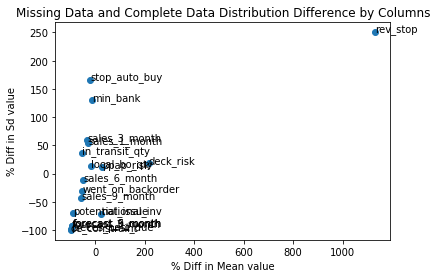

In [54]:
from matplotlib import pyplot
pyplot.scatter(x = stat_list[:,0], y = stat_list[:,1])
for i, txt in enumerate(na_stats.columns.drop(['lead_time','perf_6_month_avg','perf_12_month_avg'])):
    pyplot.annotate(txt, (stat_list[:,0][i],stat_list[:,1][i]))
pyplot.xlabel('% Diff in Mean value')
pyplot.ylabel('% Diff in Sd value')
pyplot.title('Missing Data and Complete Data Distribution Difference by Columns')
pyplot.show()

%matplotlib inline

This plot tells us that when lead_time is na, each columns's distribution is very different. To get the best prediction results, we will use other features to preict and fill missing values instead of dropping them directly. 

To do this, we first take data where all columns are complete.Then for each column in the original set with missing values, we treat that column in the complete set as target variable, and train models using other features. Finally, fill Nas in the original set with our preditions

In [55]:
from sklearn.model_selection import train_test_split
#This is the train_data with lead_time not being NA
train_complete = train_complete.sample(frac = 1,random_state = 42)
label_na = train_complete.lead_time
train_complete = train_complete.drop(labels='lead_time',axis = 1)

#This is train_data with nothing being NA
complete_index = train_complete.index[train_complete['perf_6_month_avg']>0].tolist()
train_all_complete = train_complete.loc[complete_index]
label_all_complete = label_na.loc[complete_index]
x_train_na1, x_test_na, y_train_na1, y_test_na = train_test_split(
    train_all_complete, label_all_complete, test_size=0.2, random_state=42)


In [34]:
#These functions build models, fine-tune their parameters, and provide test performance.
#Return list include the best model, the best parameter, mse performance,and the actual prediction

#Ideally I would define another function to define classifier by a string input, but we were short in
#time for this project and we'd like to keep it as simple as possible to avoid any further errors.
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import roc_auc_score,accuracy_score, confusion_matrix, f1_score

def adaboost_regression(x_train,y_train, x_test,y_test) :
    x_train_na, x_val_na, y_train_na, y_val_na = train_test_split(
    x_train, y_train, test_size=0.25, random_state=42)
    
    performance_list = []
    for i in range(15,23):
        rf = AdaBoostRegressor(n_estimators = i, random_state = 52)
        rf_model = rf.fit(X = x_train_na, y = y_train_na)
        rf_pred = rf_model.predict(x_val_na)
           
        rf_score = mean_squared_error(y_true = y_val_na, y_pred = rf_pred)
        performance_list.append(rf_score)

   
        best_n = performance_list.index(max(performance_list))+20

    rf_best = AdaBoostRegressor(n_estimators = best_n, random_state = 52)
    rf_model_best = rf_best.fit(X = x_train, y = y_train)
    rf_pred_best = rf_model_best.predict(x_test)
    score = mean_squared_error(y_true = y_test, y_pred = rf_pred_best)
    return [best_n,rf_model_best,score,rf_pred_best]

def random_forest_regression(x_train,y_train, x_test,y_test) :
    x_train_na, x_val_na, y_train_na, y_val_na = train_test_split(
    x_train, y_train, test_size=0.25, random_state=42)
    
    performance_list = []
    for i in range(18,23):
        rf = RandomForestRegressor(n_estimators = i, random_state = 52)
        rf_model = rf.fit(X = x_train_na, y = y_train_na)
        rf_pred = rf_model.predict(x_val_na)
           
        rf_score = mean_squared_error(y_true = y_val_na, y_pred = rf_pred)
        performance_list.append(rf_score)

   
        best_n = performance_list.index(max(performance_list))+20

    rf_best = RandomForestRegressor(n_estimators = best_n, random_state = 52)
    rf_model_best = rf_best.fit(X = x_train, y = y_train)
    rf_pred_best = rf_model_best.predict(x_test)
    score = mean_squared_error(y_true = y_test, y_pred = rf_pred_best)
    return [best_n,rf_model_best,score,rf_pred_best]

def random_forest_classification(x_train,y_train, x_test,y_test) :
    x_train_na, x_val_na, y_train_na, y_val_na = train_test_split(
    x_train, y_train, test_size=0.25, random_state=42)
    
    performance_list = []
    for i in range(18,23):
        rf = RandomForestClassifier(n_estimators = i, random_state = 52)
        rf_model = rf.fit(X = x_train_na, y = y_train_na)
        rf_pred = rf_model.predict(x_val_na)
           
        rf_score = mean_squared_error(y_true = y_val_na, y_pred = rf_pred)
        performance_list.append(rf_score)

   
        best_n = performance_list.index(max(performance_list))+20

    rf_best = RandomForestClassifier(n_estimators = best_n, random_state = 52)
    rf_model_best = rf_best.fit(X = x_train, y = y_train)
    rf_pred_best = rf_model_best.predict(x_test)
    score = mean_squared_error(y_true = y_test, y_pred = rf_pred_best)
    return [best_n,rf_model_best,score,rf_pred_best]

In [33]:
# This function trains 6 models with chosen algorithm. Since we have over a million observations, I played around
# with the data and determined training each model over 200,000 instances seems reasonable.

# Again, ideally I would  define a function to define classifier, but I wanted to
# keep it simple.
def ensemble_ada(x_train,y_train,x_test,y_test,interval):
    na_result_lists = [[]]
    for i in range (0,6) :
        
        start_index = i*interval
        end_index = (i+1)*interval+1
        temp_train_nax = x_train.iloc[start_index:(end_index),:]
        temp_train_nay = y_train.iloc[start_index:(end_index)]
        na_result_lists = na_result_lists + [adaboost_regression(x_train = temp_train_nax, 
                                    y_train = temp_train_nay,x_test = x_test,y_test = y_test)]

    return na_result_lists

def ensemble_rf(x_train,y_train,x_test,y_test,interval):
    na_result_lists = [[]]
    for i in range (0,6) :
        
        start_index = i*interval
        end_index = (i+1)*interval+1
        temp_train_nax = x_train.iloc[start_index:(end_index),:]
        temp_train_nay = y_train.iloc[start_index:(end_index)]
        
        na_result_lists = na_result_lists + [random_forest_regression(x_train = temp_train_nax, 
                                    y_train = temp_train_nay,x_test = x_test,y_test = y_test)]
        
    return na_result_lists

def ensemble_rfc(x_train,y_train,x_test,y_test,interval):
    na_result_lists = [[]]
    for i in range (0,6) :
        
        start_index = i*interval
        end_index = (i+1)*interval+1
        temp_train_nax = x_train.iloc[start_index:(end_index),:]
        temp_train_nay = y_train.iloc[start_index:(end_index)]
        na_result_lists = na_result_lists + [random_forest_classification(x_train = temp_train_nax, 
                                    y_train = temp_train_nay,x_test = x_test,y_test = y_test)]
    return na_result_lists

There are 3 columns with missing values: lead_time, perf_6_month, and perf_12_month. A lot of code are repetitive so ideally we could have automated it. Again, for simplicity reasons we just did copy & paste.

###  lead_time prediction

In [58]:
ada_result = ensemble_ada(x_train_na1,y_train_na1,x_test_na,y_test_na,202582)
ada_result = ada_result[1:]

In [59]:
random_forest_classifier_result = ensemble_rfc(x_train_na1,y_train_na1,x_test_na,y_test_na,202582)
random_forest_classifier_result = random_forest_classifier_result[1:]

Evaluate our performance

In [14]:
#This function ensembles all 6 models and gives the average prediction of all 6 predictors
def get_ensembled_result(na_result_lists):    
    sum_pred = np.array(na_result_lists[0][3])
    for i in na_result_lists[1:] :
        sum_pred = sum_pred + np.array(i[3])
    return sum_pred/6


In [61]:
ada_mse = mean_squared_error(y_true = y_test_na, y_pred = get_ensembled_result(ada_result))
ada_rmse = np.sqrt(ada_mse)
ada_rmse

6.6378615193486104

In [62]:
rfc_mse = mean_squared_error(y_true = y_test_na, y_pred = get_ensembled_result(random_forest_classifier_result))
rfc_rmse = np.sqrt(rfc_mse)
rfc_rmse

3.9008374863896784

random forest classifier works better. Predict missing lead_time in the training data

In [63]:
train_with_na = train_with_na.iloc[1:100893]
train_with_na = train_with_na.drop(labels='lead_time',axis = 1)

In [64]:
na_results_train = [[]]
for i in random_forest_classifier_result :
    model = i[1]
    prediction = model.predict(X = train_with_na)
    na_results_train = na_results_train + [prediction]
na_results_train = na_results_train[1:]
sum_pred = np.array(na_results_train[0])
for i in na_results_train[1:] :
    sum_pred = sum_pred + np.array(i)
average_pred_train =  np.round(sum_pred/6)
train_with_na['lead_time'] =  average_pred_train



In [65]:
train_complete['lead_time'] = label_na

In [66]:
train_comlete_data = pd.concat([train_with_na,train_complete])

Prepare test data for lead_time prediction

In [67]:

test_with_na = test_data[test_data.isnull().any(axis=1)]
test_with_na = test_with_na.iloc[1:14724,]
test_complete = test_data.dropna(axis=0, how='any')

test_with_na = test_with_na.drop(labels='lead_time',axis = 1)

Use our best models to make predictions on test_with_na for lead_time. Then replace the entire lead_time column with the average our final prediction, which is the average of results from all 6 predictors.

In [68]:
na_results_test = [[]]
for i in random_forest_classifier_result :
    model = i[1]
    prediction = model.predict(X = test_with_na)
    na_results_test = na_results_test + [prediction]
na_results_test = na_results_test[1:]
sum_pred = np.array(na_results_test[0])
for i in na_results_test[1:] :
    sum_pred = sum_pred + np.array(i)
average_pred_test =  np.round(sum_pred/6)
test_with_na['lead_time'] =  average_pred_test
test_comlete_data = pd.concat([test_with_na,test_complete])

### Perf_6_month Prediction

In [69]:
#This is the index of training data that needs to be fixed
index6_list=train_comlete_data.index[train_comlete_data['perf_6_month_avg']==-99].tolist()
train_with_perfna = train_comlete_data.loc[index6_list]



In [70]:
index6_complete_list = train_comlete_data.index[train_comlete_data['perf_6_month_avg']>0].tolist()
train_with_complete_perf = train_comlete_data.loc[index6_complete_list]

In [79]:
#Split to training+test, here use train_all_complete dataset from previous time.
train_all_complete = train_comlete_data.loc[complete_index]

perf6_label = train_all_complete.perf_6_month_avg
train_all_complete = train_all_complete.drop(labels='perf_6_month_avg',axis = 1)

x_train_perf6, x_test_perf6, y_train_perf6, y_test_perf6 = train_test_split(
    train_all_complete, perf6_label, test_size=0.2, random_state=42)

In [80]:
perf6_regressor_num = x_train_perf6.shape[0]
perf6_regressor_num

1215495

In [81]:
perf6_regressor_num/6

202582.5

In [82]:
perf6_results = [[]]
perf6_interval = 202582
for i in range (0,6) :
    start_index = i*perf6_interval
    end_index = (i+1)*perf6_interval+1
    temp_train_nax = x_train_perf6.iloc[start_index:(end_index),:]
    temp_train_nay = y_train_perf6.iloc[start_index:(end_index)]
    perf6_results = perf6_results + [random_forest_regression(x_train = temp_train_nax, 
                            y_train = temp_train_nay,x_test = x_test_perf6,y_test = y_test_perf6)]
perf6_results = perf6_results[1:]

In [ ]:
train_with_perfna = train_with_perfna.drop(labels = 'perf_6_month_avg',axis = 1)

In [87]:
#predict perf6 on train set

na_results_train = [[]]
for i in perf6_results :
    model = i[1]
    prediction = model.predict(X = train_with_perfna)
    na_results_train = na_results_train + [prediction]
na_results_train = na_results_train[1:]
sum_pred = np.array(na_results_train[0])
for i in na_results_train[1:] :
    sum_pred = sum_pred + np.array(i)
average_pred_train =  np.round(sum_pred/6)
train_with_perfna['perf_6_month_avg'] =  average_pred_train


In [89]:
train_comlete_data = pd.concat([train_with_perfna,train_with_complete_perfna])

In [90]:
test_perf6_na_index = test_comlete_data.index[test_comlete_data['perf_6_month_avg']==-99].tolist()
test_perf6_na = test_comlete_data.loc[test_perf6_na_index]

index6_complete_list_test = test_comlete_data.index[test_comlete_data['perf_6_month_avg']>0].tolist()
test_with_complete_perfna = test_comlete_data.loc[index6_complete_list_test]
test_perf6_na = test_perf6_na.drop(labels = 'perf_6_month_avg',axis = 1)

In [91]:
na_results_test = [[]]
for i in perf6_results :
    model = i[1]
    prediction = model.predict(X = test_perf6_na)
    na_results_test = na_results_test + [prediction]
na_results_test = na_results_test[1:]
sum_pred = np.array(na_results_test[0])
for i in na_results_test[1:] :
    sum_pred = sum_pred + np.array(i)
average_pred_test =  np.round(sum_pred/6)
test_perf6_na['perf_6_month_avg'] =  average_pred_test


In [92]:
test_comlete_data = pd.concat([test_perf6_na,test_with_complete_perfna])

In [96]:
train_all_complete['perf_6_month_avg'] = perf6_label

### Perf_12_month Prediction

In [95]:
#This is the index of training data that needs to be fixed
index12_list=train_comlete_data.index[train_comlete_data['perf_12_month_avg']==-99].tolist()
train_with_perfna = train_comlete_data.loc[index12_list]
index12_complete_list = train_comlete_data.index[train_comlete_data['perf_12_month_avg']>0].tolist()
train_with_complete_perf = train_comlete_data.loc[index12_complete_list]

In [97]:
#Split to training+test, here use train_all_complete dataset from previous time.
perf12_label = train_all_complete.perf_12_month_avg
train_all_complete = train_all_complete.drop(labels='perf_12_month_avg',axis = 1)

x_train_perf12, x_test_perf12, y_train_perf12, y_test_perf12 = train_test_split(
    train_all_complete, perf12_label, test_size=0.2, random_state=42)

In [98]:
perf12_regressor_num = x_train_perf12.shape[0]
perf12_regressor_num/6

202582.5

In [99]:
#Build models
perf12_results = [[]]
perf12_interval = 202582
for i in range (0,6) :
    start_index = i*perf12_interval
    end_index = (i+1)*perf12_interval+1
    temp_train_nax = x_train_perf12.iloc[start_index:(end_index),:]
    temp_train_nay = y_train_perf12.iloc[start_index:(end_index)]
    perf12_results = perf12_results + [random_forest_regression(x_train = temp_train_nax, 
                            y_train = temp_train_nay,x_test = x_test_perf12,y_test = y_test_perf12)]
perf12_results = perf12_results[1:]

In [101]:
train_with_perfna = train_with_perfna.drop(labels = 'perf_12_month_avg',axis = 1)

In [102]:
#predict perf12 on train set

na_results_train_12 = [[]]
for i in perf12_results :
    model = i[1]
    prediction = model.predict(X = train_with_perfna)
    na_results_train_12 = na_results_train_12 + [prediction]
na_results_train_12 = na_results_train_12[1:]
sum_pred = np.array(na_results_train_12[0])
for i in na_results_train_12[1:] :
    sum_pred = sum_pred + np.array(i)
average_pred_train =  np.round(sum_pred/6)
train_with_perfna['perf_12_month_avg'] =  average_pred_train


In [124]:
train_comlete_data = pd.concat([train_with_perfna,train_with_complete_perf])

In [104]:
test_perf12_na_index = test_comlete_data.index[test_comlete_data['perf_12_month_avg']==-99].tolist()
test_perf12_na = test_comlete_data.loc[test_perf12_na_index]

index12_complete_list_test = test_comlete_data.index[test_comlete_data['perf_12_month_avg']>0].tolist()
test_with_complete_perfna = test_comlete_data.loc[index12_complete_list_test]
test_perf12_na = test_perf12_na.drop(labels = 'perf_12_month_avg',axis = 1)

In [105]:
na_results_test12 = [[]]
for i in perf12_results :
    model = i[1]
    prediction = model.predict(X = test_perf12_na)
    na_results_test12 = na_results_test12 + [prediction]
na_results_test12 = na_results_test12[1:]
sum_pred = np.array(na_results_test12[0])
for i in na_results_test12[1:] :
    sum_pred = sum_pred + np.array(i)
average_pred_test12 =  np.round(sum_pred/6)
test_perf12_na['perf_12_month_avg'] =  average_pred_test12


In [106]:
test_comlete_data = pd.concat([test_perf12_na,test_with_complete_perfna])

## Feature engineering

The only modification we'd like to do is to subtract forecast numbers from each other--obviously, sales forecast for the next 9 months will include sales predictions for the next 3 and 6 months.

In [125]:
train_comlete_data[['forecast_6_month']]=train_comlete_data[['forecast_6_month']].values-train_comlete_data[['forecast_3_month']].values

train_comlete_data[['forecast_9_month']]=train_comlete_data[['forecast_9_month']].values-(train_comlete_data[['forecast_3_month']].values+train_comlete_data[['forecast_6_month']])


train_comlete_data[['sales_3_month']]=train_comlete_data[['sales_3_month']].values-train_comlete_data[['sales_1_month']].values

train_comlete_data[['sales_6_month']]=train_comlete_data[['sales_6_month']].values-(train_comlete_data[['sales_1_month']].values+train_comlete_data[['sales_3_month']].values)


train_comlete_data[['sales_9_month']]=train_comlete_data[['sales_9_month']].values-(train_comlete_data[['sales_1_month']].values+train_comlete_data[['sales_6_month']].values+train_comlete_data[['sales_3_month']].values)

In [108]:
test_comlete_data[['forecast_6_month']]=test_comlete_data[['forecast_6_month']].values-test_comlete_data[['forecast_3_month']].values

test_comlete_data[['forecast_9_month']]=test_comlete_data[['forecast_9_month']].values-(test_comlete_data[['forecast_3_month']].values+test_comlete_data[['forecast_6_month']])


test_comlete_data[['sales_3_month']]=test_comlete_data[['sales_3_month']].values-test_comlete_data[['sales_1_month']].values

test_comlete_data[['sales_6_month']]=test_comlete_data[['sales_6_month']].values-(test_comlete_data[['sales_1_month']].values+test_comlete_data[['sales_3_month']].values)


test_comlete_data[['sales_9_month']]=test_comlete_data[['sales_9_month']].values-(test_comlete_data[['sales_1_month']].values+test_comlete_data[['sales_6_month']].values+test_comlete_data[['sales_3_month']].values)


In [126]:
# Write the cleaned train data to local disk
train_comlete_data.to_csv(path_or_buf ='C:\\Users\\liuwe\\Google Drive\\Emory MSBA\\Machine Learning 2\\Final Project\\clean_train.csv',index = False)

In [121]:
# Write the cleaned test data to local disk
test_comlete_data.to_csv(path_or_buf ='C:\\Users\\liuwe\\Google Drive\\Emory MSBA\\Machine Learning 2\\Final Project\\clean_test.csv',index = False)

## Exploratory Data Analysis

<function matplotlib.pyplot.show>

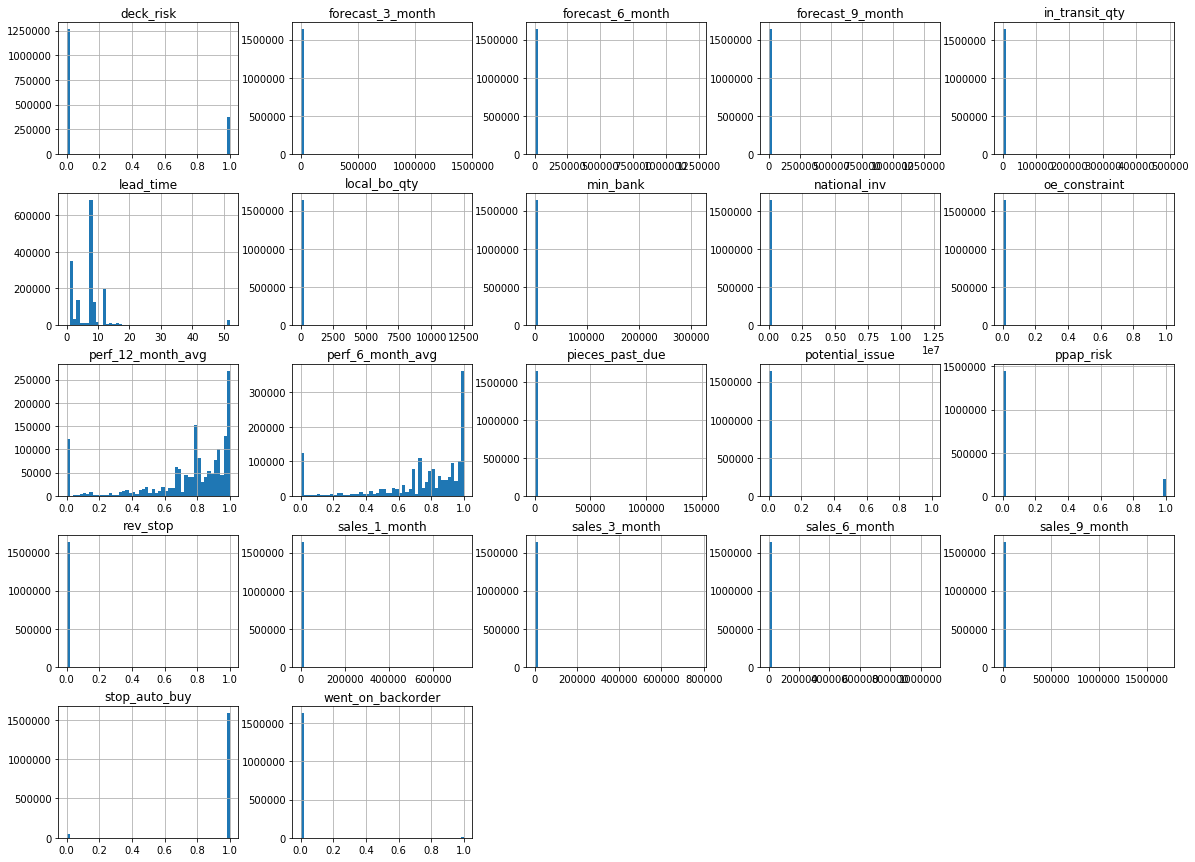

In [109]:
%matplotlib inline 
train_comlete_data.hist(bins=50,figsize=(20,15))
pyplot.show

Our variables are not highly related besides similar measurements such as sales_3_month vs sales_6_month. Therefore no obvious need for complecated feature engineering/selections.

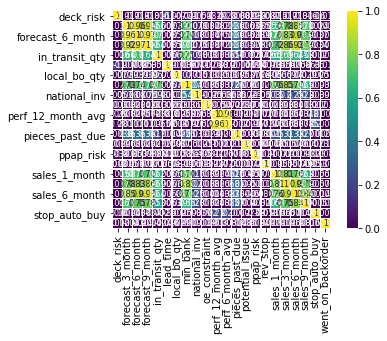

In [110]:
import seaborn as sns

corr = train_comlete_data.corr() # We already examined SalePrice correlations

sns.heatmap(corr, 
            cmap='viridis', vmax=1.0, vmin=0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

Our data is very imbalanced, which will create huge problem for modeling. We'll address this problem by over-sampling.

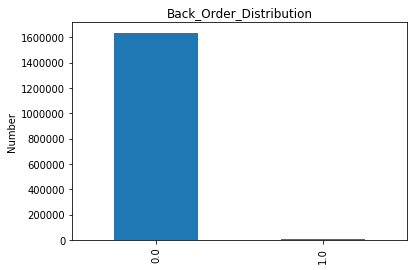

In [112]:
train_comlete_data['went_on_backorder'].value_counts().plot(kind="bar")
pyplot.title('Back_Order_Distribution')
pyplot.ylabel('Number')
pyplot.show()


## Building Models

In [127]:
y = train_comlete_data.went_on_backorder
train_comlete_data = train_comlete_data.drop(labels = 'went_on_backorder',axis = 1)
X_train, X_validation, y_train, y_validation = train_test_split(
    train_comlete_data, y, test_size = 0.3, random_state = 42)

In [ ]:
#train_comlete_data = pd.read_csv("C:\\Users\phani\Desktop\\ML2\\clean_train.csv",low_memory=False)
#test_comlete_data  = pd.read_csv("C:\\Users\phani\Desktop\\ML2\\clean_test.csv",low_memory=False)

In [128]:
#Shuffle dataset
train_comlete_data = train_comlete_data.sample(frac = 1)

Since the dataset is quite large and running models can take a long time, I took a smaller subset and played around with it before I started the actual predictions.

In [132]:
try_set_x = train_comlete_data.iloc[0:150000]

In [133]:
from sklearn.model_selection import train_test_split
try_label = y[0:150000]

try_x_train, try_x_test, try_y_train, try_y_test = train_test_split(
    try_set_x, try_label, test_size=0.3, random_state=42)

In [13]:
from sklearn.metrics import roc_auc_score,accuracy_score, confusion_matrix, f1_score,recall_score
from sklearn.linear_model import LogisticRegression 
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
def create_classifier(classifier, n):
    if(classifier == 'random_forest'):
        clf = RandomForestClassifier(n_estimators = n, random_state = 52)
    elif (classifier == 'logistic'):
        clf = LogisticRegression(C=n)
    elif (classifier == 'nnet') :
        clf = MLPClassifier(hidden_layer_sizes = (n,),alpha = 0.1)
    elif (classifier == 'adaboost'):
        clf = AdaBoostClassifier(n_estimators = n, random_state = 52)
    elif (classifier=='knn'):
        clf = KNeighborsClassifier(n_neighbors = n,leaf_size=50)
    return clf

def classification_with_metrics ( x_train_1, y_train_1, x_test,y_test,metric = 'auc',classifier = 'random_forest',
                                 range_list=[]) :
    x_train, x_val, y_train, y_val = train_test_split(
    x_train_1, y_train_1, test_size=0.25, random_state=42)
    performance_list = []
    for i in range_list:
        #keeps track of progress
        print(i)
        clf = create_classifier(classifier, i)
        clf_model = clf.fit(X = x_train, y = y_train)
        clf_pred_prob = clf_model.predict_proba(x_val)[:,1]
        if(metric == 'auc'):
            clf_score = roc_auc_score(y_true = y_val, y_score = clf_pred_prob)
        elif(metric == 'f1'):
            clf_pred_class = clf_model.predict(x_val)
            clf_score = f1_score(y_true = y_val, y_pred = clf_pred_class)
        elif(metric == 'recall'):
            clf_pred_class = clf_model.predict(x_val)
            c_matrix = confusion_matrix(y_true = y_val, y_pred = clf_pred_class
                                        ,labels = [1,0])
            clf_score = c_matrix[0,0]/(c_matrix[0,0]+c_matrix[0,1])
        performance_list.append(clf_score)

   
    best_n = range_list[performance_list.index(max(performance_list))]

    clf_best = create_classifier(classifier, best_n)
    
    clf_model_best = clf_best.fit(X = x_train_1, y = y_train_1)
    clf_pred_prob = clf_model_best.predict_proba(x_test)[:,1]
    clf_pred = clf_model_best.predict(x_test)
    
    
    auc_score = roc_auc_score(y_true = y_test, y_score = clf_pred_prob)
    f1_Score = f1_score(y_true = y_test, y_pred = clf_pred)
    c_matrix = confusion_matrix(y_true = y_test, y_pred = clf_pred,labels = [1,0])
    recall = clf_score = c_matrix[0,0]/(c_matrix[0,0]+c_matrix[0,1])
    accuracy = accuracy_score(y_true = y_test, y_pred = clf_pred)
    score = [auc_score,f1_Score,c_matrix,accuracy,recall]
    
    return [best_n,clf_model_best,score,clf_pred,clf_pred_prob]

## Actual prediction

We began our actual prediction starting from here. 

In [4]:
train_comlete_data = pd.read_csv("C:\\Users\\liuwe\\Google Drive\\Emory MSBA\\Machine Learning 2\\Final Project\\clean_train.csv",low_memory=False)
test_comlete_data  = pd.read_csv("C:\\Users\\liuwe\\Google Drive\\Emory MSBA\\Machine Learning 2\\Final Project\\clean_test.csv",low_memory=False)

Sample positive instances with replacement in order to balance our dataset.

In [7]:
train_backorder_index = train_comlete_data.index[train_comlete_data['went_on_backorder']>0].tolist()
train_backorder = train_comlete_data.loc[train_backorder_index]

train_nobackorder_index = train_comlete_data.index[train_comlete_data['went_on_backorder']==0].tolist()
train_nobackorder =train_comlete_data.loc[train_nobackorder_index]

train_oversample_backorder = train_backorder.sample(frac = 40,replace = True)
train_oversampled = pd.concat([train_oversample_backorder,train_nobackorder]).sample(frac = 1)

In [8]:
oversampled_train_label = train_oversampled.went_on_backorder
train_oversampled_x = train_oversampled.drop(labels = 'went_on_backorder', axis = 1)

final_test_label = test_comlete_data.went_on_backorder
final_test_x = test_comlete_data.drop(labels = 'went_on_backorder', axis = 1)

In [9]:
oversampled_train_label.shape

(2062976,)

Right now, the positive class is at about 26%

In [10]:
oversampled_train_label.value_counts()

0.0    1635296
1.0     427680
Name: went_on_backorder, dtype: int64

In [11]:
#Decides to divide the entire dataset into 7 smaller subsets
final_interval = oversampled_train_label.shape[0]/7
final_interval

294710.85714285716

In [18]:
def ensemble_final(x_train,y_train,x_test,y_test,interval, classifier,metric,range_list=[]):
    result_lists = [[]]
    for i in range (0,7) :
        
        start_index = i*interval
        end_index = (i+1)*interval+1
        temp_train_x = x_train.iloc[start_index:(end_index),:]
        temp_train_y = y_train.iloc[start_index:(end_index)]
        result_lists = result_lists + [classification_with_metrics(x_train_1 = temp_train_x, x_test = x_test, 
                                                  y_train_1 = temp_train_y, y_test =y_test,metric = metric,
                                                    range_list =range_list ,classifier = classifier)]
    return result_lists

In [ ]:
final_result_onlyada = ensemble_final(train_oversampled_x,oversampled_train_label,final_test_x, 
                                      final_test_label, 277984,'adaboost','auc',range(15,30))
final_result_onlyada = final_result_onlyada[1:]

In [24]:
def get_ensembled_proba(na_result_lists):    
    sum_pred = np.array(na_result_lists[0][4])
    for i in na_result_lists[1:] :
        sum_pred = sum_pred + np.array(i[4])
    return sum_pred/7


In [25]:
ada_proba = get_ensembled_proba(final_result_onlyada)

In [26]:
ada_auc = roc_auc_score(y_true = final_test_label, y_score = ada_proba)

In [27]:
ada_auc

0.92791686532855933

Try to use neural network

In [ ]:
final_result_onlynn = ensemble_final(train_oversampled_x,oversampled_train_label,final_test_x, 
                                      final_test_label, 277984,'nnet','auc',range(90,120))
final_result_onlynn = final_result_onlynn[1:]

In [29]:
nn_proba = get_ensembled_proba(final_result_onlynn)
nn_auc = roc_auc_score(y_true = final_test_label, y_score = nn_proba)
nn_auc

0.92654261968277796

In [30]:
ada_nn_auc = roc_auc_score(y_true = final_test_label, y_score = (ada_proba*7+nn_proba*7)/14)

In [35]:
ada_nn_auc

0.93303255884100533

In [ ]:
final_result_onlyrf = ensemble_final(train_oversampled_x,oversampled_train_label,final_test_x, 
                                      final_test_label, 277984,'random_forest','auc',range(15,30))
final_result_onlyrf = final_result_onlyrf[1:]

In [37]:
rf_proba = get_ensembled_proba(final_result_onlyrf)
rf_auc = roc_auc_score(y_true = final_test_label, y_score = rf_proba)
rf_auc

0.92190998794067869

In [38]:
adannrf_auc = roc_auc_score(y_true = final_test_label, y_score = (ada_proba*7+nn_proba*7+rf_proba*7)/21)

In [39]:
adannrf_auc

0.93875976648835124

In [40]:
def cut_off(x,n):
    if x <= n:
        return 0
    else :
        return 1

In [41]:
final_proba = (ada_proba*7+nn_proba*7+rf_proba*7)/21
default_prediction = np.array([cut_off(x,0.5) for x in final_proba])

In [42]:
final_result_onlyrf[0][2]

[0.88890548826124594, 0.29994465965688988, array([[   813,   1771],
        [  2024, 231381]], dtype=int64), 0.98391874197526152, 0.31462848297213625]

### Model Evaluation

In [48]:
# Function preduces confusion matrix and its visualization
from sklearn import metrics
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def Evaluation(y_Valid, y_pred) :
    cnf_matrix1 = metrics.confusion_matrix(y_Valid, y_pred)
    np.set_printoptions(precision=2)

    plt.figure()
    plot_confusion_matrix(cnf_matrix1, classes=y_Valid.unique(),
                          title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix1, classes=y_Valid.unique(), normalize=True,
                          title='Normalized confusion matrix')

    plt.show()

    print(metrics.classification_report(y_Valid, y_pred,digits = 4))
    
    print('Accuracy = ' +str(metrics.accuracy_score(y_Valid, y_pred)))

Confusion matrix, without normalization
[[229231   4174]
 [  1322   1262]]
Normalized confusion matrix
[[ 0.98  0.02]
 [ 0.51  0.49]]


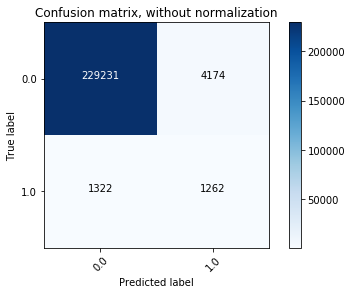

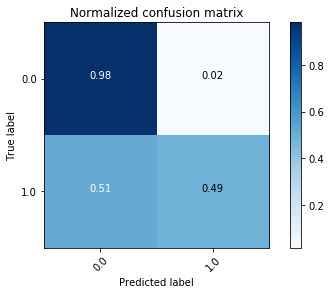

             precision    recall  f1-score   support

        0.0     0.9943    0.9821    0.9882    233405
        1.0     0.2322    0.4884    0.3147      2584

avg / total     0.9859    0.9767    0.9808    235989

Accuracy = 0.976710778892


In [49]:
Evaluation(final_test_label,default_prediction)

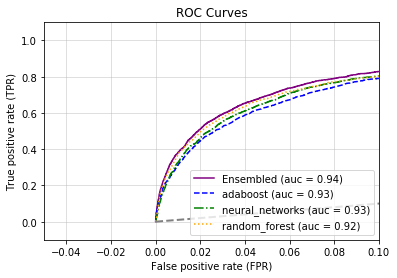

In [50]:
#Plots roc curve
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
clf_labels = ['Ensembled', 'adaboost', 'neural_networks','random_forest']
colors = [ 'purple', 'blue', 'green','orange']
predictions = [final_proba,ada_proba,nn_proba,rf_proba]
linestyles = ['-', '--', '-.', ':']
for pred, label, clr, ls in zip(predictions,clf_labels, colors, linestyles):

    y_pred = pred
    fpr, tpr, thresholds = roc_curve(y_true=final_test_label,
                                     y_score=y_pred,pos_label=1)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr,
             color=clr,
             linestyle=ls,
             label='%s (auc = %0.2f)' % (label, roc_auc))

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
         linestyle='--',
         color='gray',
         linewidth=2)

plt.xlim([-0.05, 0.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.title('ROC Curves')
plt.show()


We can also evaluate our model in a cost-sensitive schema and see how different probability thresholds result in different expected profits. The lower the probability is, the higher the risk become because we're making more and more positive predictions with lower likelihood of being positive. In another word, we can see how much profit our model could bring depending on how much risk we'd like to take. Essentially this comes down to the user's business strategy. For example if a retailer cares more about maximizing customer experience, the owner will take more risk and order more items that are not very likely to get backorders. For a business that sells perishable items, however, it'll be more conservative and only want to make positive predictions when probability is high. This is because if a perishable item is not sold within a given time frame, it'll bring a negative profit value.

In [51]:
p_threshold = np.linspace(0,1,num = 100)
#Suppose this is our cost-benefit matrix
cost_matrix = np.matrix([[500,-30],[-10,0]])

expected_value = np.array([])
for i in p_threshold:
    temp_prediction = [cut_off(x,i) for x in final_proba]
    cm = confusion_matrix(final_test_label,temp_prediction,labels = [1,0])
    result = np.sum(np.multiply(cm,cost_matrix))
    expected_value = np.append(expected_value,[result])

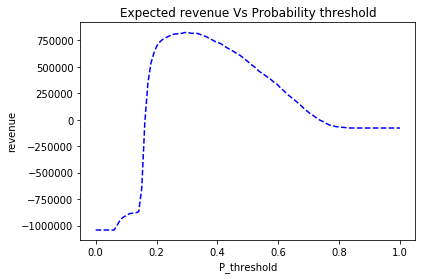

In [52]:
plt.plot(p_threshold, expected_value, 'b--')
plt.title('Expected revenue Vs Probability threshold')
plt.xlabel('P_threshold')
plt.ylabel('revenue')
plt.show()